<a href="https://colab.research.google.com/github/NilsBahr94/Master_Thesis_Algorithmic-Bias-in-AI/blob/Develop/Master_Thesis_Algorithmic_Bias_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Import packages

### Basic 

In [0]:
# Install relevant libraries
!pip install plotnine  
!pip install pandas
!pip install plotly

In [0]:
# Basic Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from pandas import DataFrame

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Learning Curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

**Fairness Tools**

In [0]:
# Installation
!pip install aif360
# https://github.com/IBM/AIF360/blob/master/examples/README.md
!pip install aequitas
# https://github.com/dssg/aequitas
!pip install audit-AI
# https://github.com/pymetrics/audit-ai
!pip install responsibly
# https://docs.responsibly.ai/

In [0]:
# Import
import aif360
import aequitas
import auditai

### What-If Tool

In [0]:
# Install current tensorflow version

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

In [0]:
# Install the What-If Tool
try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define Helper Functions for the What-If tool
import pandas as pd
import numpy as np
import witwidget

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

**Import data**

In [0]:
# Import dataset and convert to Pandas Dataframe 

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

In [0]:
# Binary encoding of label
# Encoding Binary Variables

df["Over-50K"] = df["Over-50K"].apply(lambda val:
1 if val == ">50K" else 0)

# Check if encoding was successful 
print(df["Over-50K"].dtypes)

int64


In [0]:
df.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country',
       'Over-50K'],
      dtype='object')

**Specify feature and label columns**

In [0]:
import numpy as np

# Set the column in the dataset you wish for the model to predict
label_column = 'Over-50K'

# Set list of all columns from the dataset we will use for model input.
input_features = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
                  'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
                  'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country']

# Create a list containing all input features and the label column
features_and_labels = input_features + [label_column]

**Convert dataset to tf.Example protos**

In [0]:
examples = df_to_examples(df)

**Create and train the classifier**

In [0]:
num_steps = 200  #@param {type: "number"}

# Create a feature spec for the classifier
feature_spec = create_feature_spec(df_what_if, features_and_labels)

# Define and train the classifier
train_inpf = functools.partial(tfexamples_input_fn, examples, feature_spec, label_column)
classifier = tf.estimator.LinearClassifier(
    feature_columns=create_feature_columns(input_features, feature_spec))
classifier.train(train_inpf, steps=num_steps)

In [0]:
#Invoke What-If Tool for test data and the trained models {display-mode: "form"}

num_datapoints = 2000  #@param {type: "number"}
tool_height_in_px = 1000  #@param {type: "number"}

from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

# Load up the test dataset
test_csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_df = pd.read_csv(test_csv_path, names=csv_columns, skipinitialspace=True,
  skiprows=1)
make_label_column_numeric(test_df, label_column, lambda val: val == '>50K.')
test_examples = df_to_examples(test_df[0:num_datapoints])

# Setup the tool with the test examples and the trained classifier
config_builder = WitConfigBuilder(test_examples[0:num_datapoints]).set_estimator_and_feature_spec(
    classifier, feature_spec).set_label_vocab(['Under 50K', 'Over 50K'])
a = WitWidget(config_builder, height=tool_height_in_px)

# Case Studies

## 0) Testing

**Criteria for Dataset Selection**

https://www.notion.so/techlabs/Master-Thesis-Proposal-c1550763e23c485887147f59cebc695d#350e14b5c061432189b80eb1df2a81c5

### Modeling

8) Identification of the distribution of class values (for majority and minority)

Selection of classification method:

- **Linear** machine learning algorithms often have a high bias but a low variance.
    1. Logistic Regression
    2. Linear Discriminant Analysis
    3. Partial Least Squares Discriminant Analysis
- **Nonlinear** machine learning algorithms often have a low bias but a high variance.
    1. Nonlinear Discriminant Analysis
    2. Neural Networks
    3. Flexible Discriminant Analysis
    4. Support Vector Machines 
    5. K-Nearest Neighbors
    6. Naive Bayes
- Others
    1. Basic Classification Trees
    2. Random Forest
    3. Boosted Trees

#### Training

- Prepare data for training (split by input features and labels).
- Execute train/test split (if applicable).
- Train with selected classification method.
- Predict with selected classification method.

In [0]:
# Define algorithms
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
knn = KNeighborsClassifier(n_neighbors = 5)
log_reg = LogisticRegression()
svm = SVC(C = 1.0, kernel = "rbf")

f1 = make_scorer(f1_score)

# Estimate 
print(cross_val_score(estimator = random_forest, 
                X= df_3_adult_train_input, 
                y= df_3_adult_train_label, 
                cv= 10, 
                scoring= f1))

df_3_adult_train_label
# Predict and get confusion matrix 
y_train_pred = cross_val_predict(random_forest, df_3_adult_train_input, df_3_adult_train_label, cv = 10) 
print(confusion_matrix(df_3_adult_train_label, y_train_pred)) 
print(f1_score(df_3_adult_train_label, y_train_pred))

[0.56134723 0.55464927 0.57258719 0.54681027 0.58556367 0.57491857
 0.54636591 0.59934853 0.57894737 0.54440789]
[[23791   929]
 [ 4399  3442]]
0.5637078283655421


#### Testing & Model Evaluation

1. Get basic model performance metrics. 
2. Understand the predictive ability of the features.
3. Understand class separability.
4. Understand the structure of the subpopulation.


1) Get basic model performance metrics of the base model.

In [0]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
# Get Basic Performance Statistics

# Confusion Matrix
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_train, y_train_pred))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred) # Validate if the correct data was used
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='k-NN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC Curve')
plt.show();

# AUC 
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred)) # Validate if the correct data was used

# Full Classification Metrics Report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

# Visual Model Evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

2) Understand the predictive ability of the features

See *Chapter 18.2 Categorical Outcomes* in *Applied Predictive Modeling*.

Approaches:

- Plot ROC Curve per predictor variable 
- See metrics such as p-value and gain ratio 
- Relief algorithm
- For Random Forest: Gini Importance or Mean Decrease in Impurity (MDI)
- LIME
- SHAP

See https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-understand-a-model

In [0]:
# Feature Importance for Random Forest

for i, item in enumerate(rfr.feature_importances_):
  print("{0:s}: {1:.2f}".format(X.columns[i], item))

#### Fairness Evaluation

From https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml/#2

In [0]:
# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

In [0]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [0]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [0]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

#### Learning Curve

##### Function Definition

In [0]:
# https://www.kaggle.com/grfiv4/learning-curves-1

import numpy  as np
import pandas as pd

def plot_learning_curve(estimator, title, X, y, 
                        ylim=None, cv=None, 
                        scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
  
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              For example, Log Loss is specified as 'neg_log_loss'
              
    obj_line : numeric or None (default: None)
               draw a horizontal line 
               

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
        
    Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
        
    Usage
    -----
        plot_learning_curve(estimator = best_estimator, 
                            title     = best_estimator_title, 
                            X         = X_train, 
                            y         = y_train, 
                            ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

         plt.show()
    """
    
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    # plt.style.use('seaborn')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

##### Plot Learning Curve

In [0]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
random_forest = RandomForestClassifier(n_estimators = 100, # To Do 
                                       max_depth = 12)

sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Plot actual learning curve

# plt.figure(figsize = (30,10))
plot_learning_curve(estimator = random_forest, 
                    title = "Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    cv = 10, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = sizes)

from matplotlib.pyplot import figure
# plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

##### Hyperparameter Tuning

Steps in a Grid Search:
1. An algorithm to tune the hyperparameters. (Sometimes called an ‘estimator’)
2. Defining which hyperparameters we will tune
3. Defining a range of values for each hyperparameter
4. Setting a cross-validation scheme; and
5. Define a score function so we can decide which square on our grid was "the best"
6. Include extra useful information or functions

In [0]:
# Check scores

from sklearn import metrics
sorted(metrics.SCORERS.keys())

# make scorer if that does not work with the default names

In [0]:
from sklearn import model_selection

# Create the hyperparameter grid
param_grid = {'max_depth': [2, 4, 6, 8],            # Important: Keys in the dictionary must be valid hyperparameters 
              'min_samples_leaf': [1, 2, 4, 6]}

# Define classifier
rf_grid_search = RandomForestClassifier(criterion= "entropy",
                                        max_features = "auto")

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = model,
                                                     param_grid = param_grid, 
                                                     scoring= 'f1', 
                                                     cv = 5,
                                                     refit = True, 
                                                     n_jobs = 2,
                                                     return_train_score = True)

# Further steps with best model
# We can use the best model by means of the score to fit it on our data and make predictions
grid_rf_class.fit(X_train, y_train) # To Do: specify dataset variable name
# Make predictions
grid_rf_class.predict(X_test)       # To Do: specify dataset variable name

type(grid_rf_class.best_estimator_) # grid_rf_class.best_estimator_ is an estimator that we can directly use for fitting and prediction
print(grid_rf_class.best_estimator_) # print in order to check actual final hyperparameters 

# Outputs
# Three different groups for the GridSearchCV properties;
# 1. A results log: cv_results_
# 2. The best results: best_index_ , best_params_ & best_score_
# 3. 'Extra information': scorer_ , n_splits_ & refit_time_

# Access properties with dot notation
# e.g. grid_search_object.property

cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
print(best_row)

##### Compare different algorithms

In [0]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# Define different classification algorithms
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
# knn = KNeighborsClassifier(n_neighbors = 5)
log_reg = LogisticRegression()
svm = SVC(C = 1.0, kernel = "rbf")

# Store different models in a list
models = [random_forest, log_reg, svm]

# Define other input arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Plot learning curve for different classifcation algorithms
for model in models:
  plt.subplot
  plot_learning_curve(estimator = model, 
                      title = f"{model} Learning Curve", 
                      X = df_3_adult_train_input, y = df_3_adult_train_label, 
                      cv = 10, 
                      scoring = f1, 
                      ylim = (0, 1), 
                      train_sizes = sizes)

# Plot different subplots 

# for model, i in [(RandomForestClassifier(), 1), (KNeighborsClassifier(),2)]:
#     plt.subplot(1,2,i)
#     learning_curves(estimator = model, 
#                     data = df_3_adult_dummies, 
#                     features = df_3_adult_train_input.columns, 
#                     target= "Over-50K", 
#                     train_sizes = train_sizes, 
#                     cv= 5)

In [0]:
# def data_preprocess_fair(full_dataset, 
#                          outcome_feature, 
#                          privileged_outcome_label, 
#                          discriminatory_feature, 
#                          majority_label,
#                          minority_label)


## 1) Convert the labels of the target variable into a suitable  format (binary integer)
# Encoding Binary 
df_3_adult["Over-50KVariables"] = df_3_adult["Over-50K"].apply(lambda val: 1 if val == ">50K" 
                                                               else 0)

# Check if encoding was successful 
df_3_adult["Over-50K"].dtypes

## 2. Prepare data for training (input features and label).
# Features of complete dataset
# print(df_3_adult.columns)

# Input features
df_3_adult_train_input = df_3_adult.drop(columns=["Over-50K"])
# print(df_3_adult_train_input.columns)

# Target feature
df_3_adult_train_label = df_3_adult["Over-50K"]
# print(df_3_adult_train_label)

## 3) Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy encoding)
# Dummy 
df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

## 4) Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that
# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]

# print(df_3_adult.shape)
# print(df_3_adult_black.shape)
# print(df_3_adult_white.shape)
# print(df_3_adult_female.shape)
# print(df_3_adult_male.shape)


  # """
  #   Convert the target label in an binary number format, create two different datasets sets 

  #   Parameters
  #   ----------
  #   estimator : object type that implements the "fit" and "predict" methods
  #       An object of that type which is cloned for each validation.

  #   title : string
  #       Title for the chart.

  #   X : array-like, shape (n_samples, n_features)
  #       Training vector, where n_samples is the number of samples and
  #       n_features is the number of features.

  #   y : array-like, shape (n_samples) or (n_samples, n_features), optional
  #       Target relative to X for classification or regression;
  #       None for unsupervised learning.

  #   ylim : tuple, shape (ymin, ymax), optional
  #       Defines minimum and maximum yvalues plotted.

  # """

Tasks:
1. Convert the labels of the target variable into a suitable  format (binary integer).
2. Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy coding).
3. Prepare data for training (input features and label).
4. Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that (*TBD if really the right approach*).

#### Analysis with the What-If Tool

Guide: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/xgboost_caip.ipynb?hl=de


In [0]:
# Initialization of the What-If Tool

PROJECT_ID = 'YOUR_PROJECT_ID'
MODEL_NAME = 'YOUR_MODEL_NAME'
VERSION_NAME = 'YOUR_VERSION_NAME'
TARGET_FEATURE = 'mortgage_status'
LABEL_VOCAB = ['denied', 'approved']

config_builder = (WitConfigBuilder(test_examples.tolist(), features.columns.tolist() + ['mortgage_status'])
  .set_ai_platform_model(PROJECT_ID, MODEL_NAME, VERSION_NAME, adjust_prediction=adjust_prediction)
  .set_target_feature(TARGET_FEATURE)
  .set_label_vocab(LABEL_VOCAB))

## 1) US Adult Income Dataset

UCI Adult dataset, also known as "Census Income" dataset, contains information, extracted from the 1994 census data about people with attributes such as age, occupation, education, race, sex, marital-status, native-country, hours-per-week etc., indicating whether the income of a person exceeds $50K/yr or not. It can be used in fairness-related studies that want to compare gender or race inequalities based on people’s annual incomes, or various other studies [6]. 

### Data Import

In [0]:
# Import dataset and convert to Pandas Dataframe 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df_3_adult = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

**Alternative Option**

In [0]:
# Join iso alpha codes 
from google.colab import files
uploaded = files.upload()

Saving adult (1).data to adult (1).data


In [0]:
# Store data in dataframe
import pandas as pd
import io

csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

df_3_adult = pd.read_csv(io.BytesIO(uploaded['adult (1).data']), names = csv_columns, skipinitialspace=True)# Dataset is now stored in a Pandas Dataframe

In [0]:
df_3_adult

TypeError: ignored

### Exploratory Data Analysis

*Outcomes*:

1. Understanding of the general structure of the dataset
2. Understanding of basic statistics of the features of the dataset 


In [0]:
df_3_adult.head(n=5)

In [0]:
# Number of rows and features
df_3_adult.shape

(32561, 15)

In [0]:
# List of specific features
df_3_adult.columns

In [0]:
# Datatypes of features
print(df_3_adult.dtypes)

In [0]:
df_3_adult.info

In [0]:
df_3_adult.describe()

**Summary of results**

1. Understanding of the general structure 
- Result: 
2. Understanding of basic statistics of the features of the  the dataset 
- Result: 



**Outcomes**:

1. Identification of **features** on the basis of which subpopulations can be identified and discrimination can happen
2. Identification of **values** of these features that are connected to certain subpopulations
3. Identification of the percentage of certain subpopulation based on the values of these features -> *Sample Size Disparity I*
4. Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset -> *Sample Size Disparity II*
5. Identification of the target feature and the type of class balance
6. Identification of percentage of missing values per feature
7. Identification of severity of outliers per feature
8. Identification of the distribution of class values (for majority and minority)

1) **Identification of features on the basis of which subpopulations can be identified and discrimination can happen**

-> ***Race, Sex, Country, Workclass***

In [0]:
print(df_3_adult.columns)
print(df_3_adult.columns.nunique())

2) **Identification of values of these features that are connected to certain subpopulations**

In [0]:
# Race
print(df_3_adult.Race.unique())
print(df_3_adult.Race.nunique())

['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
5


In [0]:
# Sex
print(df_3_adult.Sex.unique())
print(df_3_adult.Sex.nunique())

['Male' 'Female']
2


In [0]:
# Country
print(df_3_adult.Country.unique())
print(df_3_adult.Country.nunique())

In [0]:
# Workclass
print(df_3_adult.Workclass.unique())
print(df_3_adult.Workclass.nunique())

In [0]:
# Education
print(df_3_adult.Education.unique())
print(df_3_adult.Education.nunique())

In [0]:
# Template for Group By Statistics 
print(df_3_adult.groupby("Race")["Capital-Gain"].agg([min, max, "mean"])) 

# print(df_3_adult.groupby(["Sex", "Race"])["Capital-Gain"].mean())

`Interim Conclusion regarding 2) `

Mainly *Race* as well as *Sex* are the features on the basis of which discrimination could happen.

3) **Identification of the percentage of certain subpopulation based on the values of these features** -> *Sample Size Disparity I*

In [0]:
# Visualization of Count Columns

def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()


In [0]:
# Absolute number of members of different "races"
print(df_3_adult.Race.value_counts(dropna=False, sort=True)) # Learning: würde genauso mit df_3_adult["Race"].value_counts(dropna=False) funktionieren

# Percentage of members of different "races"
print(df_3_adult.Race.value_counts(normalize=True, dropna=False, sort=True))

In [0]:
# Distribution for Race

target_distribution(y_var="Race", data=df_3_adult)

In [0]:
# Absolute number of members of different "sexes"
print(df_3_adult.Sex.value_counts(dropna=False, sort=True))

# Percentage of members of different "sexes"
print(df_3_adult.Sex.value_counts(normalize=True, dropna=False, sort=True))

In [0]:
# Distribution for Sex

target_distribution(y_var="Sex", data=df_3_adult)

`Interim conclusion regarding 3)`



4) **Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset** -> *Sample Size Disparity II*

In [0]:
# Count
df_3_adult.groupby(['Sex', 'Race']).agg({"Over-50K": 'count'})

Over-50K
Sex    Race                        
Female Amer-Indian-Eskimo       119
       Asian-Pac-Islander       346
       Black                   1555
       Other                    109
       White                   8642
Male   Amer-Indian-Eskimo       192
       Asian-Pac-Islander       693
       Black                   1569
       Other                    162
       White                  19174

In [0]:
# Count
df_3_adult.groupby(['Over-50K', "Race"]).agg({"Race": 'count'})

In [0]:
# Alternative Count
df_3_adult_aggr = df_3_adult
df_3_adult_aggr['counting']=1
# df_3_adult_aggr.groupby(['Sex', 'Race']).agg({"counting": 'count'})

# To Do -> Jeweils verrechnen mit Grundgesamtheit von Subpopulationen

Histogram

In [0]:
# Define Histogram Function

def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)
        
    plt.show()

In [0]:
Y_columns = ["Race", "Sex"]

print(plot_histo(data = df_3_adult, col='Capital-Gain',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Capital-Loss',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Hours-per-week',Y_columns=Y_columns))

Bar Plot 

In [0]:
# Define Function for Bar Plot

def plot_bar(data, col, Y_columns, max_cat=10):
    df = data.copy()
    
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].barh(cnt.index.values, cnt.values)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Bar plot of the "+col+" column by "+y_col)

    plt.show()

In [0]:
print(df_3_adult.columns)

Y_columns = ["Race"]

print(plot_bar(data = df_3_adult, col='Sex',Y_columns=Y_columns)) # Error because values for two subplots are expected

5) **Identification of the target feature and the type of class balance**

In [0]:
print(df_3_adult["Over-50K"].value_counts(dropna=False))
print(df_3_adult["Over-50K"].value_counts(normalize=True, dropna=False))

0    24720
1     7841
Name: Over-50K, dtype: int64
0    0.75919
1    0.24081
Name: Over-50K, dtype: float64


6) **Identification of percentage of missing values per feature**

In [0]:
print(df_3_adult.isna().any())
print(df_3_adult.isna().sum())

In [0]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [0]:
assess_NA(df_3_adult)

Plot missing values per feature.

In [0]:
# Define Function 

def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100

    trace = go.Bar(x=data_null.index, y=data_null['Count'], marker=dict(color='#c0392b'),
              name = 'At least one missing value', opacity=0.9)
    layout = go.Layout(barmode='group', title='Column with missing values in the dataset', showlegend=True,
                   legend=dict(orientation="h"), yaxis=dict(title='Percentage of the dataset'))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

`Interim conclusion on 6)`

No problems with NA

**To Do**: Determine if NA are encrypted in different format.

7) **Identification of severity of outliers per feature**

Show boxplot per numeric feature

In [0]:
df_3_adult.info()

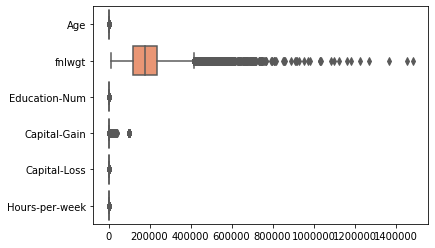

In [0]:
# Overview boxplot of all numerical features 
ax = sns.boxplot(data=df_3_adult, orient="h", palette="Set2")

In [0]:
# Age Boxplot
fig = px.box(df_3_adult, y="Age")
fig.show()

In [0]:
# Education Num
fig = px.box(df_3_adult, y="Education-Num")
fig.show()

In [0]:
# Capital Gain
fig = px.box(df_3_adult, y="Capital-Gain")
fig.show()

In [0]:
# Capital Loss
fig = px.box(df_3_adult, y="Capital-Loss")
fig.show()
# Hours per Week
fig = px.box(df_3_adult, y="Hours-per-week")
fig.show()

### Data Analysis


**Steps**
1. Specify hyperparameters for the chosen classification algorithm by means of grid search using standard ranges. Specify by means of on the dataset as a whole (full min. and maj.).
2. Specify what is the majority and what is the minority class based on a value of a feature that identifies groups that are at risk of being discriminated. 
3. First, take the whole dataset with the majority and the minority class. Then, filter the dataset such that the majority class is fixed in size and only a certain number of training examples that are considered for the minority class is considered. Change this number step-by-step. For each step, train a random forest and test by mans of 10-fold cross validation.
4. Attach the final outcome predictions  to the individual dataframes of the different datsets with diff. min. group sizes as seperate feature. -> *Open questions: is that manageable because we have different models (e.g. by means of majority vote of the 10 models with regards to classification)? If not possible then necessary to store the metric information directly without data frame as intermediate step (for that check calculation of fairness metric) (-> then also easier to store validation score to have an underfit/overfit check) OR use train/test split instead of k-fold cv (least prefered)*
- a) Then filter that dataset so that only the minority group is displayed. Then, calculate  the confusion matrix and the F1-score. 
- b) Calculate the fairness metric by means of comparing the predictions for the minority class with the prediction for the majority class (check: https://aif360.readthedocs.io/en/latest/modules/metrics.html#binary-label-dataset-metric).
5. Store the F1-score and the fairness metric for each training set size in a data frame. The data frame should have the following features: 
- a) Absolute number of training examples for the minority group, 
- b) percentage share of the minority group in the majority, 
- c) F-1 score for the min. group (maybe also seperately including std. dev. upper and lower bound), 
- d) fairness metric based on the min. & maj. group prediction comparisons. **Extended**: in case the fairness metric is not in the range of [0, 1] like the F1-score, normalize/standardize it (make sure that this is not biasing/altering the metrics results).
6. Based on the data frame from step 5, plot a learning curve that shows the relationship between the different absolute sizes of training examples and the performance and fairness metric.

In [0]:
# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

###### 0) Preparation

In [0]:
# DATA IMPORT

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
               "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
               "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df_3_adult = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

In [9]:
df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'})

,Over-50K
Over-50K,
<=50K,24720
>50K,7841


In [0]:
# Define Data Preprocessing Function

def fair_preprocess(data, label, neg_class, pos_class):

  ''' Applies binary encoding on the values of the label feature.

  Returns two datasets in the following order: data_input_features and data_label. '''

  # Binary encoding
  data[label] = data[label].replace({neg_class: 0, pos_class: 1})

  # Create separate dataset version for input features and label
  data_input_features = data.drop(columns=[label])
  data_label = data[label]

  return data_input_features, data_label

In [0]:
# Execute preprocessing function
df_3_adult_train_input, df_3_adult_train_label = fair_preprocess(data = df_3_adult, 
                                                                 label = "Over-50K", 
                                                                 neg_class = "<=50K", 
                                                                 pos_class = ">50K")

In [0]:
# Check whether binary encoding was successful and seperate datasets were created
print(df_3_adult.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))
print(df_3_adult_train_input.columns)

###### 1) Define hyperparameters.

Specify hyperparameters for the chosen classification algorithm by means of grid search using standard ranges. Specify by means of on the dataset as a whole (full min. and maj.).

In order to set training_size, check the number of training examples in the minority class.

In [103]:
# HYPERPARAMETER TUNING

from sklearn import model_selection

# Create the hyperparameter grid
# Important: Keys in the dictionary must be valid hyperparameters 
param_grid = {"n_estimators": [10, 25, 50, 75, 100, 200, 300],
              "max_depth": [2, 5, 8, 15, 25, 30],        
              "min_samples_split": [2, 5, 10, 15, 100],
              "min_samples_leaf": [1, 2, 5, 10]}

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

# Define classifier
rf_grid_search = RandomForestClassifier(criterion= "gini",
                                        max_features = "auto")

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define model
f1 = make_scorer(f1_score)

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = rf_grid_search,
                                                     param_grid = param_grid, 
                                                     scoring= f1,
                                                     n_jobs = 2, 
                                                     cv = 5,
                                                     refit = True,
                                                     return_train_score = True)

# Dummy Coding
df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

# Fit model
grid_rf_class.fit(df_3_adult_train_input, df_3_adult_train_label) # To Do: specify dataset variable name

print(grid_rf_class.best_params_)
print(grid_rf_class.best_estimator_) # print in order to check actual final hyperparameters

ValueError: ignored

In [0]:
type(grid_rf_class.best_estimator_) # grid_rf_class.best_estimator_ is an estimator that we can directly use for fitting and prediction

###### 2) Create datasets with diff. minority group sizes.

First, take the whole dataset with the majority and the minority class. Then, filter the dataset such that the majority class is fixed in size and only a certain number of training examples that are considered for the minority class is considered. Change this number step-by-step. 

In [0]:
# Determine number of training examples for the examples that are at risk of being discriminated
print(df_3_adult.groupby(['Race', "Over-50K"]).agg({"Over-50K": 'count'}))

                             Over-50K
Race               Over-50K          
Amer-Indian-Eskimo 0              275
                   1               36
Asian-Pac-Islander 0              763
                   1              276
Black              0             2737
                   1              387
Other              0              246
                   1               25
White              0            20699
                   1             7117


In [0]:
# Function to create datasets with different minority group sizes

def create_datasets_new(min_data: pd.DataFrame, maj_data: pd.DataFrame, training_sizes: list):
    datasets = []
    for training_size in training_sizes:
        dataset_min_sample = min_data.sample(n=training_size, random_state=1)
        dataset = pd.concat((dataset_min_sample, maj_data))
        datasets.append(dataset)
    return datasets

In [15]:
# Define arguments

# training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 
                    # 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 
                    # 4000, 4250, 4500, 4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 
                  300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 
                  1500, 1750, 2000, 2250, 2500, 2750, 3000]

# Creating dfs for minority and majority group
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
df_3_adult_black = df_3_adult[is_black]  # Minority
df_3_adult_white = df_3_adult[is_white]  # Majority

# Execute function
list_dfs = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes)
print(len(list_dfs))
print([df.shape[0] for df in list_dfs])

31
[27821, 27826, 27836, 27846, 27856, 27866, 27891, 27916, 27941, 27966, 27991, 28016, 28066, 28116, 28166, 28216, 28266, 28316, 28416, 28516, 28616, 28716, 28816, 29066, 29316, 29566, 29816, 30066, 30316, 30566, 30816]


In [0]:
df_test = list_dfs[15]
print(df_test.groupby(["Over-50K"]).agg({"Over-50K": 'count'}))

          Over-50K
Over-50K          
0            21046
1             7170


###### 3) Get metrics based on classifier.

Train a Random Forest classifier with prespecified hyperparameters on the different dataset sizes and test by means of 10-fold cross validation.

a) Get F1-score per iteration for the minority group.

b) Get fairness metrics per iteration for the comparison of the minority and majority group.

**Or**: get final prediction outcomes per training example per iteration. Then continue with 5) to calculate the metrics on my own. 

Save the following metrics per iteration:

- Index -> Counting upwards per row
- Number of total training examples

Minority Group
- Number of training examples for minority group
- F1 score for minority group
- TPR, FPR, TNR, FNR for minority group

Majority Group
- Number of training examples for majority group
- F1 score for majority group
- TPR, FPR, TNR, FNR for majority group

Calculate afterwards:
- Relative share of minority group of the total training examples
- Fairness metrics 

In [0]:
def metrics_to_df(list_dfs, label, model, cv, discr_feature, min_value, maj_value):

  # Import relevant modules
  from sklearn.model_selection import cross_val_predict
  import sklearn.metrics
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score
  from sklearn.metrics import recall_score
  from sklearn.metrics import confusion_matrix
  from sklearn.ensemble import RandomForestClassifier

  # Initialize lists for metrics 
  # COMPLETE
  rows_compl_list = [] 
  f1_compl_list = []
  # MINORITY
  rows_min_list = [] 
  f1_min_list = []
  tpr_min_list = []
  fpr_min_list = []
  prob_y_1_min_list = []
  # MAJORITY
  rows_maj_list = []
  f1_maj_list = []
  tpr_maj_list = []
  fpr_maj_list = []
  prob_y_1_maj_list = []


  for dataset_var in list_dfs:

      # Define Input and target columns
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]                 # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

      ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input,
                                       df_train_label,
                                       cv = cv)

      # Append prediction labels to original dataset
      dataset_var['y_pred'] = y_train_pred

      # Create dataset for MINORITY group 
      is_black = dataset_var[discr_feature].isin([min_value])
      df_check_black = dataset_var[is_black] 

      # Create dataset for MAJORITY group
      is_white = dataset_var[discr_feature].isin([maj_value])
      df_check_white = dataset_var[is_white] 

      ## METRICS
      # Get metrics for the COMPLETE dataset
      # NUMBER OF ROWS
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)   
      # F1
      f1_compl = f1_score(df_train_label, y_train_pred) 
      f1_compl_list.append(f1_compl) 

      # Get metrics for the MINORITY group
      # NUMBER OF ROWS
      rows_min = len(df_check_black.index)
      rows_min_list.append(rows_min)
      # F1
      f1_min = f1_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
      f1_min_list.append(f1_min)
      # TPR/RECALL
      tpr_min = recall_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      tpr_min_list.append(tpr_min)
      # FPR/SPECIFICITY
      tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black[label], df_check_black["y_pred"], labels=[0,1]).ravel()
      fpr_min = tn_min / (tn_min+fp_min)
      fpr_min_list.append(fpr_min)
      # Cond. Prob. P(y=1|minority)
      filter_race_black_y_1 = dataset_var[discr_feature].isin([min_value]) & dataset_var["y_pred"].isin([1])
      filter_race_black = dataset_var[discr_feature].isin([min_value])
      prob_race_black_y_1 = len(dataset_var[filter_race_black_y_1].index) / len(dataset_var[filter_race_black].index)
      prob_y_1_min_list.append(prob_y_1_min)

      # Get metrics for the MAJORITY group
      # NUMBER OF ROWS
      rows_maj = len(df_check_white.index)
      rows_maj_list.append(rows_maj)
      # F1
      f1_maj = f1_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      f1_maj_list.append(f1_maj)
      # TPR/RECALL
      tpr_maj = recall_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) #average='weighted'
      tpr_maj_list.append(tpr_maj)
      # FPR/SPECIFICITY
      tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white[label], df_check_white["y_pred"], labels=[0,1]).ravel()
      fpr_maj = tn_maj / (tn_maj+fp_maj)
      fpr_maj_list.append(fpr_maj)
      # Cond. Prob. P(y=1|minority)
      filter_race_white_y_1 = dataset_var[discr_feature].isin([maj_value]) & dataset_var["y_pred"].isin([1])
      filter_race_white = dataset_var[discr_feature].isin([maj_value])
      prob_race_white_y_1 = len(dataset_var[filter_race_white_y_1].index) / len(dataset_var[filter_race_white].index)
      prob_y_1_maj_list.append(prob_race_white_y_1)

  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                             "rows_minority": rows_min_list,
                             "rows_majority": rows_maj_list, 
                             'f1_complete': f1_compl_list,
                             'f1_minority': f1_min_list,
                             'f1_majority': f1_maj_list,
                             'tpr_minority': tpr_min_list,
                             "prob_yhat_1_minority": prob_y_1_min_list,
                             "tpr_majority": tpr_maj_list,
                             "fpr_minority": fpr_min_list,
                             "fpr_majority": fpr_maj_list,
                             "prob_yhat_1_majority": prob_y_1_maj_list})

  # Calculate new metric columns and append to df 
  results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"])
  # FAIRNESS METRICS
  # Average Absolute Odds Difference -> The closer to 0, the fairer.
  results_df["aver_abs_odds_diff"] = 0.5*(abs(results_df["fpr_minority"] - results_df["fpr_majority"])+abs(results_df["tpr_minority"] - results_df["tpr_majority"])) 
  # Statistical Parity Difference -> The closer to 0, the fairer.
  results_df["stat_parity_diff"] =  results_df["prob_yhat_1_minority"] - results_df["prob_yhat_1_majority"]
  # Equal Opportunity Distance -> The closer to 0, the fairer.
  results_df["equal_opport_dist"] = results_df["tpr_minority"] - results_df["tpr_majority"]  
  # Disparate Impact -> The closer to 1, the fairer.
  results_df["disparate_impact"] =  results_df["prob_yhat_1_minority"] / results_df["prob_yhat_1_majority"]

  return(results_df)

In [0]:
# Prepare groupby data
filter_race_black_y_1 = df_check["Race"].isin(["Black"]) & df_check["y_pred"].isin([1])
filter_race_white_y_1 = df_check["Race"].isin(["White"]) & df_check["y_pred"].isin([1])

filter_race_black = df_check["Race"].isin(["Black"])
filter_race_white = df_check["Race"].isin(["White"])

prob_race_black_y_1 = len(df_check[filter_race_black_y_1].index) / len(df_check[filter_race_black].index)
prob_race_white_y_1 = len(df_check[filter_race_white_y_1].index) / len(df_check[filter_race_white].index)

print(prob_race_black_y_1)
print(prob_race_white_y_1)


# rating_probs = df_check.groupby("Race").size().div(len(df_check))
# groupby_probs = df_check.groupby(['y_pred', "Race"]).size().div(len(df_check)).div(rating_probs, axis=0, level="Race")
# print(groupby_probs)

# Experiments identify how to subset groupby in order to get right conditional probability 
rating_probs = df_check.groupby('Race').size().div(len(df_check))
print(df_check.groupby(['y_pred', 'Race']).size().div(len(df_check)).div(rating_probs, axis=0, level='Race'))
group_df_1 = df_check.groupby(['y_pred', 'Race']).size().div(len(df_check)).div(rating_probs, axis=0, level='Race')
# list_groupby = list(group_df_1)
# print(list_groupby)
# print(list_groupby[2])
# print(list_groupby[3])

# print(group_df_1[[2]])
# print(group_df_1[[3]])
# test = group_df_1[[3]]
# print(test)

# # Create list
# list_groupby_probs = list(groupby_probs)
# print(list_groupby_probs)
# prob_y_1_min = list_groupby_probs[2]
# print(prob_y_1_min)

# prob_y_1_maj = list_groupby_probs[3]
# print(prob_y_1_maj)

# # Cond. Prob. P(y=1|minority)

0.0
0.11737848720161058
y_pred  Race 
0       Black    1.000000
        White    0.882622
1       White    0.117378
dtype: float64


In [0]:
# Define arguments
list_dfs = list_dfs
label = "Over-50K"
model = RandomForestClassifier(criterion= "gini",
                               max_features = "auto",
                               max_depth = 4,
                               min_samples_leaf = 4,
                               n_estimators = 100)
# model = grid_rf_class # <- Best model from hyperparameter tuning
cv = 10
discr_feature = "Race"
min_value = "Black"
maj_value = "White"

# Execute function
results_df = metrics_to_df(list_dfs = list_dfs, label = label, model = model, cv = cv, 
                           discr_feature = discr_feature, min_value = min_value, maj_value = maj_value)
results_df

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



,rows_complete,rows_minority,rows_majority,f1_complete,f1_minority,f1_majority,tpr_minority,prob_yhat_1_minority,tpr_majority,fpr_minority,fpr_majority,prob_yhat_1_majority,rel_share_min_of_maj,aver_abs_odds_diff,stat_parity_diff,equal_opport_dist,disparate_impact
0,27821,5,27816,0.525145,0.000000,0.525145,0.000000,0.117019,0.381481,1.000000,0.975458,0.115869,0.000180,0.203012,0.001150,-0.381481,1.009929
1,27826,10,27816,0.509869,0.000000,0.509869,0.000000,0.117019,0.364760,1.000000,0.977294,0.110224,0.000360,0.193733,0.006795,-0.364760,1.061644
2,27836,20,27816,0.522170,0.000000,0.522323,0.000000,0.117019,0.377266,1.000000,0.976859,0.113747,0.000719,0.200203,0.003271,-0.377266,1.028761
3,27846,30,27816,0.528189,0.000000,0.528393,0.000000,0.117019,0.385696,1.000000,0.974492,0.117666,0.001079,0.205602,-0.000647,-0.385696,0.994500
4,27856,40,27816,0.518439,0.000000,0.518691,0.000000,0.117019,0.375299,1.000000,0.975313,0.114395,0.001438,0.199993,0.002624,-0.375299,1.022942
5,27866,50,27816,0.521327,0.000000,0.521731,0.000000,0.117019,0.378671,0.976744,0.974926,0.115545,0.001798,0.190244,0.001474,-0.378671,1.012757
6,27891,75,27816,0.516756,0.153846,0.517215,0.090909,0.117019,0.373612,0.984375,0.975554,0.113783,0.002696,0.145762,0.003236,-0.282703,1.028436
7,27916,100,27816,0.519644,0.285714,0.520120,0.187500,0.117019,0.376844,0.976190,0.975168,0.114898,0.003595,0.095183,0.002121,-0.189344,1.018461
8,27941,125,27816,0.510518,0.370370,0.510889,0.238095,0.117019,0.365885,0.990385,0.977149,0.110620,0.004494,0.070513,0.006399,-0.127789,1.057849
9,27966,150,27816,0.528178,0.344828,0.528691,0.227273,0.117019,0.385134,0.984375,0.975313,0.116911,0.005393,0.083462,0.000108,-0.157861,1.000923


###### a. Test functions step-by-step

In [0]:
df_check = list_dfs[1]
df_check.groupby(["Over-50K"]).agg({"Over-50K": 'count'})

,Over-50K
Over-50K,
0,21046
1,7170


In [0]:
# TEST FUNCTION 

# Import relevant modules
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Get specific Dataframe from list of dataframes
df_check = list_dfs[5]

# Define Input and target columns
label = "Over-50K"
df_train_input = df_check.drop(columns=[label])  # Input
df_train_label = df_check[label]                 # Target

# Apply dummy coding
df_train_input = pd.get_dummies(df_train_input)

## TRAIN & TEST
# Define model
rf_test = RandomForestClassifier(criterion= "gini", 
                                 max_features = "auto",
                                 max_depth = 4,
                                 min_samples_leaf = 4,
                                 n_estimators = 100)
# Predict 
y_train_pred = cross_val_predict(rf_test,
                                 df_train_input, 
                                 df_train_label, 
                                 cv = 10)

# Append prediction labels to original dataset
df_check['y_pred'] = y_train_pred

# Create dataset version for minority class 
is_black = df_check["Race"].isin(["Black"]) 
df_check_black = df_check[is_black]  # Minority group
# Create dataset version for majority class
is_white = df_check["Race"].isin(["White"])
df_check_white = df_check[is_white] # Majority group


## METRICS
# Get metrics for the COMPLETE dataset
rows_compl_list = [] 
rows_compl = len(df_check.index)
rows_compl_list.append(rows_compl)

f1_compl_list = []
f1_compl = f1_score(df_train_label, y_train_pred) 
f1_compl_list.append(f1_compl) 

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)) 
# -> https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

# Get metrics for the MINORITY group
# NUMBER OF ROWS
rows_min_list = [] 
rows_min = len(df_check_black.index)
rows_min_list.append(rows_min)
# F1
f1_min_list = []
f1_min = f1_score(df_check_black["Over-50K"], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
f1_min_list.append(f1_min)
# TPR, RECALL
tpr_min_list = []
tpr_min = recall_score(df_check_black["Over-50K"], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
tpr_min_list.append(tpr_min)
# FPR, SPECIFICITY
fpr_min_list = []
tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black["Over-50K"], df_check_black["y_pred"], labels=[0,1]).ravel()
fpr_min = tn_min / (tn_min+fp_min)
fpr_min_list.append(fpr_min)

# Get metrics for the MAJORITY group
# NUMBER OF ROWS
rows_maj_list = [] 
rows_maj = len(df_check_white.index)
rows_maj_list.append(rows_maj)
# F1
f1_maj_list = []
f1_maj = f1_score(df_check_white["Over-50K"], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
f1_maj_list.append(f1_maj)
# TPR, RECALL
tpr_maj_list = []
tpr_maj = recall_score(df_check_white["Over-50K"], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) #average='weighted'
tpr_maj_list.append(tpr_maj)
# FPR, SPECIFICITY
fpr_maj_list = []
tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white["Over-50K"], df_check_white["y_pred"], labels=[0,1]).ravel()
fpr_maj = tn_maj / (tn_maj+fp_maj)
fpr_maj_list.append(fpr_maj)


# Store metrics for different iterations in Data Frame
results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                           "rows_minority": rows_min_list,
                           "rows_majority": rows_maj_list, 
                           'f1_complete': f1_compl_list,
                           'f1_minority': f1_min_list,
                           'f1_majority': f1_maj_list,
                           'tpr_minority': tpr_min_list,
                           "tpr_majority": tpr_maj_list,
                           "fpr_min": fpr_min_list,
                           "fpr_maj": fpr_maj_list})

# Calculate new columns and append to df 
results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"]) 
# TBD if this calculation is correct that way or if (min/(maj+min))*100

# results_df

In [0]:
# Get train scores

f1 = make_scorer(f1_score)

cross_val_results = cross_validate(estimator = rf_test, 
                                  X = df_train_input, y = df_train_label, cv = 10, 
                                  scoring = f1, return_train_score=True)

f1_avg_train_score = np.mean(cross_val_results["train_score"])


###### 4) Create dataframe.

Attach the final outcome predictions  to the individual dataframes of the different datsets with diff. min. group sizes as seperate feature. -> *Open questions: is that manageable because we have different models (e.g. by means of majority vote of the 10 models with regards to classification)? If not possible then necessary to store the metric information directly without data frame as intermediate step (for that check calculation of fairness metric) (-> then also easier to store validation score to have an underfit/overfit check) OR use train/test split instead of k-fold cv (least prefered)*
- a) Then filter that dataset so that only the minority group is displayed. Then, calculate  the confusion matrix and the F1-score. 
- b) Calculate the fairness metric by means of comparing the predictions for the minority class with the prediction for the majority class (check: https://aif360.readthedocs.io/en/latest/modules/metrics.html#binary-label-dataset-metric).

b) Calculate the fairness metric by means of comparing the predictions for the minority class with the prediction for the majority class (check: https://aif360.readthedocs.io/en/latest/modules/metrics.html#binary-label-dataset-metric).

###### 5) Create visualization.

In [0]:
# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

%matplotlib inline

(ggplot(data = mpg)         # defining what data to use
 + aes(x='class')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

## 2) COMPAS Dataset

The COMPAS dataset contains records for defendants from Broward County indicating their jail and prison times, demographics, criminal histories, and COMPAS risk scores from 2013 to 2014 [75].

See: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS.ipynb#scrollTo=67DYIFxoevt2

### Data Import

In [0]:
# Read training dataset from CSV

# TO DO: Check if dataset from link below matches dataset from Github repository: https://github.com/propublica/compas-analysis/

df_1_compas = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')
df_1_compas


### Exploratory Data Analysis

In [0]:
# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

%matplotlib inline

(ggplot(data = mpg)         # defining what data to use
 + aes(x='class')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

### Modeling

In [0]:
# Split into training and test set

#### Training

#### Testing & Model Evaluation

Inspiration: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Age_Regression.ipynb#scrollTo=jlwjF-Nnmoww

In [0]:
# Installation of the What-If Tool

try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define helper functions

import pandas as pd
import numpy as np
import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64) or df[f].dtype is np.dtype(np.int32):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64) or df[col].dtype is np.dtype(np.int32):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

Hint

## 3) Homicide Dataset

### Data Import

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2_Homicides_database.csv to 2_Homicides_database (2).csv


In [0]:
import _io
df_2_homicide = pd.read_csv(io.StringIO(uploaded['2_Homicides_database (2).csv'].decode('utf-8')))
df_2_homicide

In [0]:
# Initialize Data Import option 

from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = "https://drive.google.com/open?id=1x27KDf6_fgqYHwccAb6U4h3HAh60eK2z"
df_2_homicide = pd.read_csv(path)
# Dataset is now stored in a Pandas Dataframe

### Exploratory Data Analysis 1

### Data Preprocessing

### Exploratory Data Analysis 2

### Modeling

## 4) German Credit Dataset

The German Credit dataset contains 1000 credit records containing attributes such as personal status and sex, credit score, credit amount, housing status etc. It can be used in studies about gender inequalities on credit-related issues [42].

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]  # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_4_german = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_4_german

## 5) Communities and Crime Dataset

The Communities and Crime dataset gathers information from different communities in the United States related to several factors that can highly influence some common crimes such as robberies, murders or rapes. The data includes crime data obtained from the 1990 US LEMAS survey and the 1995 FBI Unified Crime Report. It also contains socio-economic data from the 1990 US Census.

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"] # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_5_communities = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_5_communities

## 6) FICO score credit dataset

In [0]:
responsibly.dataset
# https://docs.responsibly.ai/dataset.html

# Generalizable Rule 

## Learning Curves

Helpful Links: 

-   https://github.com/laxmimerit/Learning-Curve-Machine-Learning-in-Python-KGP-Talkie/blob/master/Learning%20Curve%20Machine%20Learning%20in%20Python%20KGP%20Talkie.ipynb -> Learning Curve Tutorial
-   https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
-   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html



In [0]:
# Import all relevant packages and modules

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

### Templates

**Learning Curve Variant 1**



In [0]:
# Define plot_curve function

def plot_curve():
    # instantiate
    lg = LinearRegression()

    # fit
    lg.fit(X, y)
    
    
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    train_sizes, train_scores, test_scores = learning_curve(lg, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

Compared to the theory we covered, here our y-axis is 'score', not 'error', so the higher the score, the better the performance of the model.

Training score (red line) decreases and plateau
Indicates underfitting
High bias
Cross-validation score (green line) stagnating throughout
Unable to learn from data
Low scores (high errors)
Should tweak model (perhaps increase model complexity)

**Learning Curve Variant 2**

In [0]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Implementation on Case Study Datasets

# Deprecated

In [0]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
  
    """Learning curve.

    Determines cross-validated training and test scores for different training
    set sizes.

    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.

    Read more in the :ref:`User Guide <learning_curve>`.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

        .. versionchanged:: 0.22
            ``cv`` default value if None changed from 3-fold to 5-fold.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    exploit_incremental_learning : boolean, optional, default: False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    pre_dispatch : integer or string, optional
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The string can
        be an expression like '2*n_jobs'.

    verbose : integer, optional
        Controls the verbosity: the higher, the more messages.

    shuffle : boolean, optional
        Whether to shuffle training data before taking prefixes of it
        based on``train_sizes``.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Used when ``shuffle`` is True.

    error_score : 'raise' or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised. This parameter
        does not affect the refit step, which will always raise the error.

    return_times : boolean, optional (default: False)
        Whether to return the fit and score times.

    Returns
    -------
    train_sizes_abs : array, shape (n_unique_ticks,), dtype int
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.

    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    fit_times : array, shape (n_ticks, n_cv_folds)
        Times spent for fitting in seconds. Only present if ``return_times``
        is True.

    score_times : array, shape (n_ticks, n_cv_folds)
        Times spent for scoring in seconds. Only present if ``return_times``
        is True.

    Notes
    -----
    See :ref:`examples/model_selection/plot_learning_curve.py
    <sphx_glr_auto_examples_model_selection_plot_learning_curve.py>`
    """
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train_test_proportions.append((train[:n_train_samples], test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret

In [0]:
def metrics_to_df(list_dfs, label, model, cv, discr_feature, min_value, maj_value):

  # Import relevant modules
  from sklearn.model_selection import cross_val_predict
  import sklearn.metrics
  from sklearn.metrics import make_scorer
  from sklearn.metrics import f1_score
  from sklearn.metrics import recall_score
  from sklearn.metrics import confusion_matrix
  from sklearn.ensemble import RandomForestClassifier

  for dataset_var in list_dfs:

      # Define Input and target columns
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]                 # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

      ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input,
                                       df_train_label,
                                       cv = cv)

      # Append prediction labels to original dataset
      dataset_var['y_pred'] = y_train_pred

      # Create dataset for MINORITY group 
      is_black = dataset_var[discr_feature].isin([min_value])
      df_check_black = dataset_var[is_black] 

      # Create dataset for MAJORITY group
      is_white = dataset_var[discr_feature].isin([maj_value])
      df_check_white = dataset_var[is_white] 

      ## METRICS
      # Get metrics for the COMPLETE dataset
      rows_compl_list = [] 
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)

      f1_compl_list = []
      f1_compl = f1_score(df_train_label, y_train_pred) 
      f1_compl_list.append(f1_compl) 

      # Get metrics for the MINORITY group
      # NUMBER OF ROWS
      rows_min_list = [] 
      rows_min = len(df_check_black.index)
      rows_min_list.append(rows_min)
      # F1
      f1_min_list = []
      f1_min = f1_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))  # or labels = [0,1]
      f1_min_list.append(f1_min)
      # TPR/RECALL
      tpr_min_list = []
      tpr_min = recall_score(df_check_black[label], df_check_black["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      tpr_min_list.append(tpr_min)
      # FPR/SPECIFICITY
      fpr_min_list = []
      tn_min, fp_min, fn_min, tp_min = confusion_matrix(df_check_black[label], df_check_black["y_pred"], labels=[0,1]).ravel()
      fpr_min = tn_min / (tn_min+fp_min)
      fpr_min_list.append(fpr_min)

      # Get metrics for the MAJORITY group
      # NUMBER OF ROWS
      rows_maj_list = [] 
      rows_maj = len(df_check_white.index)
      rows_maj_list.append(rows_maj)
      # F1
      f1_maj_list = []
      f1_maj = f1_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"]))
      f1_maj_list.append(f1_maj)
      # TPR/RECALL
      tpr_maj_list = []
      tpr_maj = recall_score(df_check_white[label], df_check_white["y_pred"], labels=np.unique(df_check_black["y_pred"])) #average='weighted'
      tpr_maj_list.append(tpr_maj)
      # FPR/SPECIFICITY
      fpr_maj_list = []
      tn_maj, fp_maj, fn_maj, tp_maj = confusion_matrix(df_check_white[label], df_check_white["y_pred"], labels=[0,1]).ravel()
      fpr_maj = tn_maj / (tn_maj+fp_maj)
      fpr_maj_list.append(fpr_maj)

  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'rows_complete': rows_compl_list,
                              "rows_minority": rows_min_list,
                              "rows_majority": rows_maj_list, 
                              'f1_complete': f1_compl_list,
                              'f1_minority': f1_min_list,
                              'f1_majority': f1_maj_list,
                              'tpr_minority': tpr_min_list,
                              "tpr_majority": tpr_maj_list,
                              "fpr_min": fpr_min_list,
                              "fpr_maj": fpr_maj_list})

  # Calculate new metric columns and append to df 
  results_df["rel_share_min_of_maj"] = (results_df["rows_minority"] / results_df["rows_majority"]) 

  return(results_df)

In [0]:
# DATA PREPROCESSING manually
# Encoding Binary 

df_3_adult["Over-50K"] = df_3_adult["Over-50K"].replace({'<=50K': 0, '>50K': 1})

# Check if encoding was successful 
df_3_adult["Over-50K"].dtypes

# Input features
df_3_adult_train_input = df_3_adult.drop(columns=["Over-50K"])

# Target feature
df_3_adult_train_label = df_3_adult["Over-50K"]

In [0]:
# Encoding Binary 
# df_3_adult["Over-50K"] = df_3_adult["Over-50K"].apply(lambda val: 1 if val == ">50K" else val == 0)
# df_3_adult["Over-50K"] = df_3_adult["Over-50K"].replace(to_replace=['<=50K', '>50K'], value=[0, 1])

In [0]:
## OLD FUNCTION

label = "Over-50K"
model = grid_rf_class # <- Best model from hyperparameter tuning
list_dfs = list_dfs

def metrics_to_df(list_dfs, label, model, cv = 10):

  for dataset_var in list_dfs:
  
    ## DATA PREPROCESSING
      # Seperate dataset by input features and labels
      df_train_input = dataset_var.drop(columns=[label])  # Input
      df_train_label = dataset_var[label]]                # Target

      # Apply dummy coding
      df_train_input = pd.get_dummies(df_train_input)

    ## TRAIN & TEST
      # Predict 
      y_train_pred = cross_val_predict(model,
                                       df_train_input, 
                                       df_train_label, 
                                       cv = cv)
    
    ## METRICS
      # Get metrics for the COMPLETE dataset

      # confusion_matrix(df_train_label, y_train_pred) 

      rows_compl_list = [] 
      rows_compl = len(dataset_var.index)
      rows_compl_list.append(rows_compl)

      f1_compl_list = []
      f1_compl = f1_score(df_train_label, y_train_pred)
      f1_compl_list.append(f1_compl) 

      # Band for difference in Training and Validation Set
        # train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, 
                                                                # n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std  = np.std(train_scores, axis=1)
        test_scores_mean  = np.mean(test_scores, axis=1)
        test_scores_std   = np.std(test_scores, axis=1)
        plt.grid()

      # Get metrics for the MINORITY group
        
        row_min_list = []
        rows_min = len(dataset_min.index)
        row_min_list.append(rows_min)

        # TPR
        # FPR
        # TNR
        # FNR

        f1_min_list = []
        f1_min = f1_score(df_train_label, y_train_pred)
        f1_min_list.append()

      # Get metrics for the MAJORITY group

        # Number of rows
        row_maj_list = []
        rows_maj = len(dataset_maj.index)
        row_maj_list.append(rows_maj)

        # TPR
        # FPR
        # TNR
        # FNR
      
        f1_maj_list = []
        f1_maj = f1_score(df_train_label, y_train_pred)
        f1_maj_list.append()


  # Store metrics for different iterations in Data Frame
  results_df = pd.DataFrame({'Total_rows':rows_compl_list, 
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list,
                             'f1_complete':f1_compl_list})
  
  # Setting a column as an index
  # dogs_ind = dogs.set_index("name")

  return(results_df)

Calculate Confusion Matrix Cell Metrics

In [0]:
## DEPRECATED

  # neighbors_list = list(range(5,500, 5))
  # accuracy_list = []
  # for test_number in neighbors_list:
  # model = KNeighborsClassifier(n_neighbors=test_number)
  # predictions = model.fit(X_train, y_train).predict(X_test)
  # accuracy = accuracy_score(y_test, predictions)
  # accuracy_list.append(accuracy)
  # results_df = pd.DataFrame({'neighbors':neighbors_list, 'accuracy':accuracy_list})

  # # Initialize df 
  # algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs']) # To Do: Change metrics here

  # def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
  #     return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
  #                                             columns=['model', 'fair_metrics', 'prediction', 'probs'], 
  #                                             index=[name]))

In [0]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['number_training_examples', 'rel_share_min', 'min_f1', "total_f1", 'fairness metric'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], 
                                            index=[name]))
    
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)
    
    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

# Fairness Metric
import aif360
import aequitas
import auditai

# 1: Average Absolute Odd Difference
average_abs_odds_difference()
# https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference
    def average_odds_difference(self):
        r"""Average of difference in FPR and TPR for unprivileged and privileged
        groups:

        .. math::

           \tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
           + (TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}))\right]

        A value of 0 indicates equality of odds.
        """
        return 0.5 * (self.difference(self.false_positive_rate)
                    + self.difference(self.true_positive_rate))

# This metric's scale would need to be "reversed", presumably.

# 2: Equal Opportunity Distance
equal_opportunity_difference()
# https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference

    def equal_opportunity_difference(self):
        """Alias of :meth:`true_positive_rate_difference`."""
        return self.true_positive_rate_difference()

# ClassificationMetric and BinaryLabelDatasetMetric.

# Template:

# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
# algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])
# def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
#     return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [0]:
# def get_tpr(y_actual, y_hat): # Two lists: original outcomes and prediction outcomes
#     TP = 0
#     FN = 0
#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#            TP += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#            FN += 1
#     TPR = TP/(TP+FN)

# Calculation of confusion matrix rates

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)

Approach 2: Take slices of dataset

In [0]:
# Slice code for minority example

# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]


# Dummy coding for slice

df_3_adult_black_dummies = pd.get_dummies(df_3_adult_black)

# Features of complete dataset
print(df_3_adult.columns)

# Input features
df_3_adult_black_input = df_3_adult_black_dummies.drop(columns=["Over-50K"])
print(df_3_adult_black_input.columns)

# Target feature
df_3_adult_black_label = df_3_adult_black_dummies["Over-50K"]
print(df_3_adult_black_label)

# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
sizes_minority = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
                  350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
                  2000, 2250, 2500, 2750] 

# Plot actual learning curve
plot_learning_curve(estimator = random_forest, 
                    title = "Random Forest Learning Curve", 
                    X = df_3_adult_black_input, y = df_3_adult_black_label, 
                    cv = 10, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = sizes_minority)

from matplotlib.pyplot import figure
# plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

Fairness Metric per Iteration

https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb

In [0]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

# Define protected class
dataset_orig = df_3_adult(
    protected_attribute_names=['Race'],           
    privileged_classes="White",     
    features_to_drop=['personal_status', 'sex'] 
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'Race': "White"}]
unprivileged_groups = [{'Race': "Black"}]


# Convert dataset into aif360 adequate form
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [0]:
df = pd.DataFrame(regr.predict(diabetes_X_test))

rfc_model_3 = RandomForestClassifier(n_estimators=200)
rfc_model_3.predict(X_test)

X_test['survived'] = rfc_model_3.predict(X_test)

In [0]:
# Inspect original Learning Curve function
import inspect
from sklearn.model_selection import learning_curve
lines = inspect.getsource(learning_curve)
print(lines)

In [0]:
# # Function to get TPR, FPR, usw.

# # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# def perf_measures(y_actual, y_hat): # Two lists: original outcomes and prediction outcomes
#     TP = 0
#     FP = 0
#     TN = 0
#     FN = 0

#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#            TP += 1
#         if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
#            FP += 1
#         if y_actual[i]==y_hat[i]==0:
#            TN += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#            FN += 1

#     # Calculation of confusion matrix rates
#     # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP/(TP+FN)
#     # Specificity or true negative rate
#     TNR = TN/(TN+FP) 
#     # Precision or positive predictive value
#     PPV = TP/(TP+FP)
#     # Negative predictive value
#     NPV = TN/(TN+FN)
#     # Fall out or false positive rate
#     FPR = FP/(FP+TN)
#     # False negative rate
#     FNR = FN/(TP+FN)
#     # False discovery rate
#     FDR = FP/(TP+FP)

#     return TPR, FPR, TNR, FNR

In [0]:
# Deprecated CONFUSION MATRIX RATES

# tpr_min_list = []
# tpr_min = get_tpr(df_check_black["Over-50K"], df_check_black["y_pred"])
# tpr_min_list.append(tpr_min)

# tpr_min_list = [] 
# fpr_min_list = []
# tnr_min_list = []
# fnr_min_list = []
# tpr_min, fpr_min, tnr_min, fnr_min = perf_measures(df_check_black["Over-50K"], df_check_black["y_pred"])
# tpr_min_list.append(tpr_min)
# fpr_min_list.append(fpr_min)
# tnr_min_list.append(tnr_min)
# fnr_min_list.append(fnr_min)

# tpr_maj_list = []
# fpr_maj_list = []
# tnr_maj_list = []
# fnr_maj_list = []
# tpr_maj, fpr_maj, tnr_maj, fnr_maj = perf_measures(df_check_white["Over-50K"], df_check_white["y_pred"])
# tpr_maj_list.append(tpr_maj)
# fpr_maj_list.append(fpr_maj)
# tnr_maj_list.append(tnr_maj)
# fnr_maj_list.append(fnr_maj)

#  "tpr_majority": tpr_maj_list
#  "tpr_minority": tpr_min_list
#  "fpr_majority": fpr_maj_list
#  "fpr_minority": fpr_min_list
#  "tnr_majority": tnr_maj_list
#  "tnr_minority": tnr_min_list
#  "fnr_majority": fnr_maj_list
#  "fnr_minority": fnr_min_list

In [0]:
# def create_datasets_new(min_data: pd.DataFrame, maj_data: pd.DataFrame, training_sizes: list):
#     datasets = []
#     for training_size in training_sizes:
#         
#             dataset_min_sample = min_data.sample(n=training_size, random_state=1)
#             dataset = pd.concat((dataset_min_sample, maj_data))
#             datasets.append(dataset)
#     return datasets

In [0]:
import inspect
lines = inspect.getsource(learning_curve)
print(lines)

In [0]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
    """Learning curve.

    Determines cross-validated training and test scores for different training
    set sizes.

    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.

    Read more in the :ref:`User Guide <learning_curve>`.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

        .. versionchanged:: 0.22
            ``cv`` default value if None changed from 3-fold to 5-fold.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    exploit_incremental_learning : boolean, optional, default: False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    pre_dispatch : integer or string, optional
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The string can
        be an expression like '2*n_jobs'.

    verbose : integer, optional
        Controls the verbosity: the higher, the more messages.

    shuffle : boolean, optional
        Whether to shuffle training data before taking prefixes of it
        based on``train_sizes``.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Used when ``shuffle`` is True.

    error_score : 'raise' or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised. This parameter
        does not affect the refit step, which will always raise the error.

    return_times : boolean, optional (default: False)
        Whether to return the fit and score times.

    Returns
    -------
    train_sizes_abs : array, shape (n_unique_ticks,), dtype int
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.

    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    fit_times : array, shape (n_ticks, n_cv_folds)
        Times spent for fitting in seconds. Only present if ``return_times``
        is True.

    score_times : array, shape (n_ticks, n_cv_folds)
        Times spent for scoring in seconds. Only present if ``return_times``
        is True.
    """
    
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train_test_proportions.append((train[:n_train_samples], test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret

In [0]:

# min_dataset_list = list()
# compl_dataset_list = list()

# is_black = df_3_adult["Race"].isin(["Black"])
# is_white = df_3_adult["Race"].isin(["White"])
# def create_datasets(min_data, maj_data, training_sizes):
#     for training_size in training_sizes:
#         while len(min_data.index) >= training_size: # Code should stop when number of rows of df with min. group is smaller than training size iteration
#             dataset_min_slice = min_data.sample(n = training_size, random_state = 1) # Get a random subset of the minority group
#             min_dataset_list.append(dataset_min_slice) # Create list of data frames that include observations of minority group of different sizes
#             for min_dataset_component in min_dataset_list:
#                 dataset_list = maj_data.append(min_dataset_component) # Merge observations of min. group of different sizes with observations from maj. group
#                 compl_dataset_list.append(dataset_list) # Create list of data frames that include majority group (fixed size) and minority group (different sizes)
#                 return compl_dataset_list

# training_sizes_2 = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 
                      300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750]

# list_dfs_2 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_2)
# print(len(list_dfs_2))
# print([df.shape[0] for df in list_dfs_2])

# training_sizes_3 =  [2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500]

# list_dfs_3 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_3)
# print(len(list_dfs_3))
# print([df.shape[0] for df in list_dfs_3])

# training_sizes_4 = [4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000]

# list_dfs_4 = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes_4)
# print(len(list_dfs_4))
# print([df.shape[0] for df in list_dfs_4])

# # Execute function
# training_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
#                   350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
#                   2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
#                   4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000]

# df_3_adult_black = df_3_adult[is_black]  # Define minority group based on original data frame
# df_3_adult_white = df_3_adult[is_white]  # Define majority group based on original data frame

# list_dfs = create_datasets_new(min_data = df_3_adult_black, maj_data = df_3_adult_white, training_sizes = training_sizes)

In [0]:
# df_3_adult_train_input
# df_3_adult_train_label

# # Row bind
# df1.append(df2)

# def get_min_datasets(data, ):
#   for specific_size in min_sizes:
#     if n_row(dataset) >= specific_size:
#     elif n_row(dataset) < specific_size:
#       stop
#     dataset_min_slice = training_examples.sample(frac=1) # shuffle dataset with minority group randomely before slicing
#     dataset_min_slice = dataset_min_slice.slice[min_sizes]
#     diff_min_datasets.append(dataset_min) #

In [0]:
# Ggf. feature importance für jede Iteration auch noch berechnen und dann ans DF anhängen

# Sample Code

# neighbors_list = [3,5,10,20,50,75]      # use either the one or the other neighbors_list 
# neighbors_list = list(range(5,500, 5))
# print(np.linspace(1,2,5))

# accuracy_list = []
# for test_number in neighbors_list:
#   model = KNeighborsClassifier(n_neighbors=test_number)
#   predictions = model.fit(X_train, y_train).predict(X_test)
#   accuracy = accuracy_score(y_test, predictions)
#   accuracy_list.append(accuracy)

  # Because I will be working with k-fold cv, most likely I will need to take the average 
  # and define the standard deviation (which then can also be shown in the plot as bands)

  # Important: Get score both training and testing 

# results_df = pd.DataFrame({'neighbors':neighbors_list, 'accuracy':accuracy_list})
# print(np.linspace(1,2,5))

# Matplotlib plotting code -> Alternatively, use plotly

# plt.plot(results_df['neighbors'],
# results_df['accuracy'])
# # Add the labels and title
# plt.gca().set(xlabel='n_neighbors', ylabel='Accuracy',
# title='Accuracy for different n_neighbors')
# plt.show()


# Dataframe 

# results_df = pd.DataFrame(results_list, columns=['learning_rate', 'max_depth', 'accuracy'])
# print(results_df)


In [0]:
# II. Model setup
# a) Linear

# b) Nonlinear
# K-NN
# knn = KNeighborsClassifier(n_neighbors=6) # To Do: Check appropriatness of hyperparameter
# knn.fit(df_3_adult_train_input, df_3_adult_train_label) 
# To Do: Probably wrong because whole dataset and not only training set is used as input training

# c) Others
# Random Forest
# random_forest = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs =-1)
#  random_forest.fit(df_3_adult_train_input, df_3_adult_train_label)
# To Do: Probably wrong because whole dataset and not only training set is used as input training

In [0]:
# Execute train/test split.

# Check: Probably not necessary 

# Execute Train/test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_3_adult_train_input, 
#                                                     df_3_adult_train_label, 
#                                                     test_size=0.3, 
#                                                     random_state=21) # seed for random number generator

In [0]:
# Plot Alternative 2
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
    go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [0]:
# Plot Alternative 1
# fig = px.bar(df_3_adult_aggr, x="Race", y="counting", color='Sex', barmode='group')
# fig.show()

# Hint: Does not work properly.

# Plot Alternative 2
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
#     go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
# ])
# # Change the bar mode
# fig.update_layout(barmode='group')
# fig.show()

## Learning Curve Variants

### Variant 1

In [0]:
# Define Learning Curve Function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [0]:
plot_learning_curve(estimator = random_forest, title = "Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    axes=None, ylim=None, cv=10, train_sizes=sizes)
 
# models = []

# for model in models:
#   plot_learning_curve(estimator=model, title="k-nn Learning Curve", X = df_3_adult_train_input, y = df_3_adult_train_label, 
#                     axes=None, ylim=None, cv=10,
#                     n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

### Variant 2

In [0]:
!pip install yellowbrick

In [0]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Encode the categorical data
X = df_3_adult_train_input
y = df_3_adult_train_label

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
# sizes = np.linspace(0.1, 1.0, 10)
sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    model = random_forest, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Variant 3

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# train_sizes = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

from sklearn.model_selection import learning_curve

# features = df_3_adult_train_input.columns
# target = df_3_adult_train_label

train_sizes, train_scores, validation_scores = learning_curve(estimator = random_forest, 
                                                              X = df_3_adult_train_input, 
                                                              y = df_3_adult_train_label, 
                                                              cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a knn model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

In [0]:
### Bundling our previous work into a function ###

def learning_curves(estimator, data, features, target, train_sizes, cv, scoring):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, data[features], data[target], train_sizes = train_sizes,
        cv = cv, scoring = scoring)
    
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

In [0]:
### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize = (16,5))

for model, i in [(RandomForestClassifier(), 1)]:
    plt.subplot(1,2,i)
    learning_curves(estimator = random_forest, 
                    data = df_3_adult_dummies, 
                    features = df_3_adult_train_input.columns, 
                    target= "Over-50K", 
                    train_sizes = sizes,
                    scoring = f1, 
                    cv= 10)